In [32]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Load the dataset
data = pd.read_csv("../Datasets/Marketing campaign dataset.csv")

# Select relevant features
selected_columns = [
    'campaign_item_id', 'advertiser_id', 'ext_service_name', 'creative_id', 'creative_width', 
    'creative_height', 'search_tags', 'template_id', 'channel_name', 'campaign_budget_usd', 
    'media_cost_usd', 'impressions', 'clicks', 'time', 'weekday_cat'
]

data = data[selected_columns]

# Convert time to datetime for later use
data['time'] = pd.to_datetime(data['time'])

# Encode categorical features
le = LabelEncoder()
categorical_cols = ['campaign_item_id', 'advertiser_id', 'ext_service_name', 'channel_name', 'weekday_cat', 'search_tags']
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Display the processed data
print(data.head())

   campaign_item_id  advertiser_id  ext_service_name  creative_id  \
0                 0              0                 1         1000   
1                 0              0                 0         1000   
2                 0              0                 1         1000   
3                 0              0                 1         1000   
4                 0              0                 2         1000   

   creative_width  creative_height  search_tags  template_id  channel_name  \
0           300.0            250.0            2         90.0             1   
1           300.0            250.0            0         90.0             3   
2           300.0            250.0            1         90.0             3   
3           300.0            250.0            0         90.0             4   
4           300.0            250.0            0         90.0             1   

   campaign_budget_usd  media_cost_usd  impressions  clicks       time  \
0           652.173913       14.058514    

In [19]:
# Check for null values in the dataset
null_values = data.isnull().sum()

# Display columns with null values (if any)
print("Null values in each column:\n", null_values)

# To check if there are any rows with missing values in the entire dataset
print("Total rows with any missing values:", data.isnull().any(axis=1).sum())

Null values in each column:
 campaign_item_id          0
advertiser_id             0
ext_service_name          0
creative_id               0
creative_width         3412
creative_height        3412
search_tags               0
template_id            3412
channel_name              0
campaign_budget_usd       0
media_cost_usd            0
impressions               0
clicks                    0
time                      0
weekday_cat               0
dtype: int64
Total rows with any missing values: 3412


In [20]:
# Fill null values in specific columns with 0
columns_to_fill = ['creative_width', 'creative_height']
data[columns_to_fill] = data[columns_to_fill].fillna(0)

# Verify the changes
print(data[columns_to_fill].isnull().sum())  # Should show 0 for all these columns
print(data.head())  # To see the updated dataset

creative_width     0
creative_height    0
dtype: int64
   campaign_item_id  advertiser_id  ext_service_name  creative_id  \
0                 0              0                 1         1000   
1                 0              0                 0         1000   
2                 0              0                 1         1000   
3                 0              0                 1         1000   
4                 0              0                 2         1000   

   creative_width  creative_height  search_tags  template_id  channel_name  \
0           300.0            250.0            2         90.0             1   
1           300.0            250.0            0         90.0             3   
2           300.0            250.0            1         90.0             3   
3           300.0            250.0            0         90.0             4   
4           300.0            250.0            0         90.0             1   

   campaign_budget_usd  media_cost_usd  impressions  clicks  

In [21]:
data["template_id"].describe()
data["template_id"].isnull().sum()  # Count of missing values
print(data["template_id"].unique())

[90. 23. 92. 89. 93. nan]


In [22]:
data["template_id"] = data["template_id"].fillna(data["template_id"].mean())

In [23]:
import networkx as nx

# Initialize an empty graph
G = nx.Graph()

# Adding nodes and edges
for idx, row in data.iterrows():
    # Campaign Node
    campaign_id = row['campaign_item_id']
    G.add_node(campaign_id, entity='campaign', budget=row['campaign_budget_usd'],
               media_cost=row['media_cost_usd'], impressions=row['impressions'], 
               clicks=row['clicks'], time=row['time'])
    
    # Advertiser Node
    advertiser_id = row['advertiser_id']
    G.add_node(advertiser_id, entity='advertiser')
    G.add_edge(campaign_id, advertiser_id, relationship='belongs_to')

    # Platform Node
    platform = row['ext_service_name']
    G.add_node(platform, entity='platform')
    G.add_edge(campaign_id, platform, relationship='runs_on')

    # Creative Node
    creative_id = row['creative_id']
    G.add_node(creative_id, entity='creative', width=row['creative_width'], height=row['creative_height'])
    G.add_edge(campaign_id, creative_id, relationship='uses')
    
    # Channel Node
    channel = row['channel_name']
    G.add_node(channel, entity='channel')
    G.add_edge(campaign_id, channel, relationship='published_in')
    
    # Day Type Node (Weekday/Weekend)
    day_type = row['weekday_cat']
    G.add_node(day_type, entity='day_type')
    G.add_edge(campaign_id, day_type, relationship='runs_on_day')

# Optionally extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
G = nx.relabel_nodes(G, str)  # Relabel nodes to strings if required


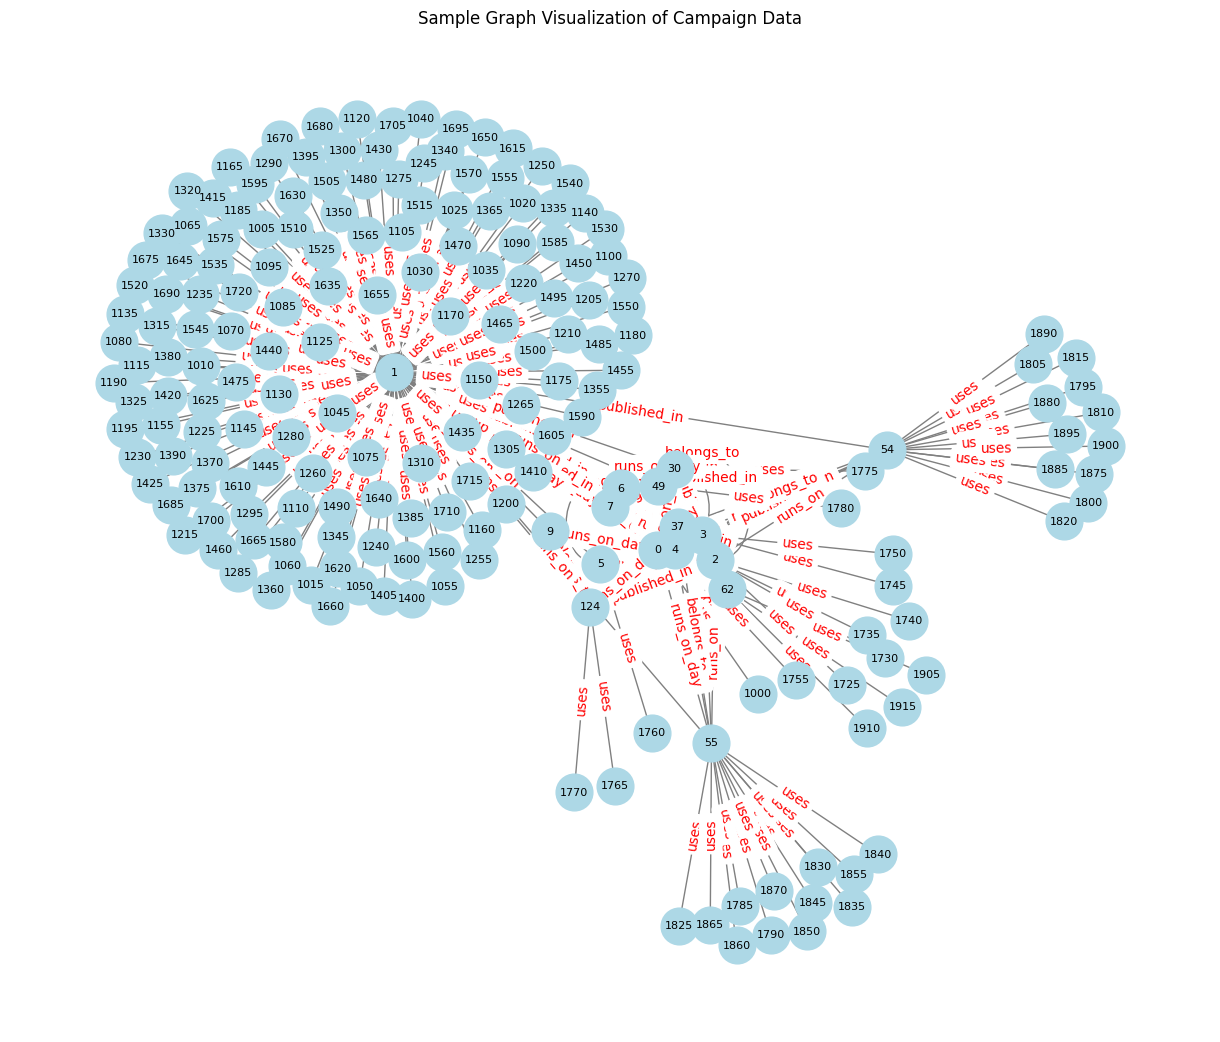

In [24]:
# Visualize the graph (showing a sample subgraph for clarity)
subgraph = G.subgraph(list(G.nodes)[:200])  # Limit visualization to 20 nodes for simplicity
pos = nx.spring_layout(subgraph, seed=42)  # Consistent layout for repeated plots
plt.figure(figsize=(12, 10))
nx.draw(subgraph, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=8, font_color="black", edge_color="gray")
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels={(u, v): d['relationship'] for u, v, d in subgraph.edges(data=True)}, font_color="red")
plt.title("Sample Graph Visualization of Campaign Data")
plt.show()

In [25]:
data[data["campaign_item_id"] == 1].value_counts()

campaign_item_id  advertiser_id  ext_service_name  creative_id  creative_width  creative_height  search_tags  template_id  channel_name  campaign_budget_usd  media_cost_usd  impressions  clicks  time        weekday_cat
1                 1              0                 1005         0.0             0.0              0            23.000000    0             760.0                9.375291        611          10      2022-06-11  0              1
                  2              1                 1405         0.0             0.0              0            23.000000    0             325.0                4.839766        885          15      2022-07-02  0              1
                                                   1365         0.0             0.0              4            23.000000    0             325.0                14.176867       1405         33      2022-06-01  0              1
                                                                                                 3           

In [26]:
from node2vec import Node2Vec

# Initialize Node2Vec model
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the model and generate embeddings
model = node2vec.fit()

# Retrieve embeddings for each ad node
ad_embeddings = {node: model.wv[node] for node in G.nodes()}

c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing transition probabilities: 100%|██████████| 3079/3079 [00:03<00:00, 942.36it/s] 


In [27]:
# Convert embeddings to a DataFrame
embedding_df = pd.DataFrame.from_dict(ad_embeddings, orient='index')
embedding_df.columns = [f'embedding_{i}' for i in range(embedding_df.shape[1])]

# Merge embeddings with original data (keeping relevant features and target variables)
final_data = data.merge(embedding_df, left_on='creative_id', right_index=True)

# Save the preprocessed dataset for training
final_data.to_csv("preprocessed_data.csv", index=False)

ValueError: You are trying to merge on int64 and object columns for key 'creative_id'. If you wish to proceed you should use pd.concat

In [28]:
import networkx as nx

# Initialize an empty graph
G = nx.Graph()

# Adding nodes and edges with features
for idx, row in data.iterrows():
    # Campaign Node
    campaign_id = row['campaign_item_id']
    if not G.has_node(campaign_id):
        G.add_node(
            campaign_id,
            entity='campaign',
            budget=row['campaign_budget_usd'],
            media_cost=row['media_cost_usd'],
            impressions=row['impressions'],
            clicks=row['clicks'],
            time=row['time']
        )

    # Add relationships as edges with weights
    # Campaign to Advertiser
    advertiser_id = row['advertiser_id']
    G.add_edge(
        campaign_id, advertiser_id, 
        relationship='belongs_to', 
        weight=row['campaign_budget_usd']
    )

    # Campaign to Platform
    platform = row['ext_service_name']
    G.add_edge(
        campaign_id, platform, 
        relationship='runs_on', 
        weight=row['impressions']
    )

    # Campaign to Creative
    creative_id = row['creative_id']
    G.add_edge(
        campaign_id, creative_id, 
        relationship='uses', 
        weight=row['clicks']
    )

    # Campaign to Channel
    channel = row['channel_name']
    G.add_edge(
        campaign_id, channel, 
        relationship='published_in', 
        weight=row['media_cost_usd']
    )

    # Campaign to Day Type (Weekday/Weekend)
    day_type = row['weekday_cat']
    G.add_edge(
        campaign_id, day_type, 
        relationship='runs_on_day', 
        weight=1.0  # Static weight for categorical data
    )

# Optionally extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# Relabel nodes to strings (Node2Vec requires string labels)
G = nx.relabel_nodes(G, str)


In [29]:
from node2vec import Node2Vec

# Initialize Node2Vec model
node2vec = Node2Vec(
    G, 
    dimensions=64,  # Embedding size
    walk_length=30,  # Length of each walk
    num_walks=200,  # Number of walks per node
    workers=4  # Parallelization factor
)

# Fit the model and generate embeddings
model = node2vec.fit()

# Retrieve embeddings for all nodes
node_embeddings = {node: model.wv[node] for node in G.nodes()}

# Example: Print the embedding for a specific node
print(node_embeddings['0'])  # Replace '0' with a node ID


Computing transition probabilities: 100%|██████████| 3079/3079 [00:02<00:00, 1062.97it/s]


[ 0.6282873   0.1318958  -0.22018676 -0.18976155  0.11841115 -0.42668772
 -0.3134668  -0.54250216 -0.48863536 -0.25244486  0.00998831 -0.042696
 -0.5239632   0.50464314 -0.0700691   0.52879995  0.58635736 -0.05036533
  0.14955658  0.16610351 -0.00909287  0.07289639  0.13587308 -0.04319192
  0.01842214  0.2275284  -0.5582736  -0.35348082  0.17427677  0.19771108
 -0.25408277  0.27766967  0.07064229 -0.3023883  -0.24312842 -0.5726242
 -0.36386654 -0.3033917  -0.41554996  0.45988482 -0.33540833 -0.40100008
  0.37611818 -0.55371225 -0.13222402  0.04825781  0.27294725 -0.34721756
  0.30863068  0.2112348   0.33971438  0.02153128 -0.09813712  0.17321248
 -0.16998206 -0.5374097   0.31194454 -0.12008809  0.01679815  0.2733844
 -0.11916302 -0.34175712  0.6100019  -0.11950399]


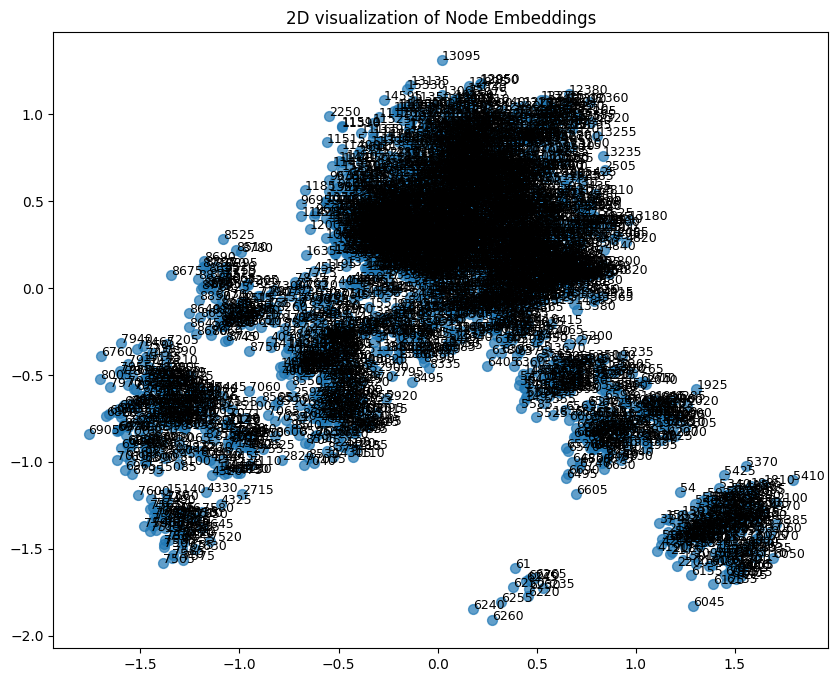

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(list(node_embeddings.values()))

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=50, alpha=0.7)

# Annotate points with node ids
for i, node in enumerate(node_embeddings.keys()):
    plt.annotate(node, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("2D visualization of Node Embeddings")
plt.show()


In [33]:
embedding_matrix = np.array([node_embeddings[str(campaign_id)] for campaign_id in data['campaign_item_id']])
engagement_target = data['clicks']
X = embedding_matrix
y = engagement_target

In [34]:
from sklearn.model_selection import train_test_split

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 58089
Test set size: 14523


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 98936.55878307692
